In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorly as tl

Using numpy backend.


In [13]:
%matplotlib inline

## Load previously compiled data

The raw (ping-by-ping) data were averaged to get mean volume backscattering strengh (MVBS) and then cleaned up by PCP. This is the same set of data I used to run the Matlab PALM-NMF.

Note that **all echograms in this notebook are plotted upside-down**, so the DVM you see you opposite of what actually happens. In reality the animals move toward the surface during the night and move downward during the day.

In [14]:
# Load PCP-cleaned MVBS data
MVBS_path = '/home/wu-jung/code_git/ooi_sonar/sample_data/'
MVBS_fname = '20150817-20151017_MVBS_PCPcleaned.h5'

import h5py
f = h5py.File(os.path.join(MVBS_path,MVBS_fname),'r')

In [15]:
# Load low-rank data
L = np.array(f['L'])
L_sep = np.array(f['L_sep'])
L_plot = np.array(f['L_plot'])
depth_bin_size = np.array(f['depth_bin_size'])
ping_per_day_mvbs = np.array(f['ping_per_day_mvbs'])
ping_time = np.array(f['ping_time'])
f.close()

The data is organized with dimension [frequency x number of days x depth x time of day].

In [16]:
L_sep.shape

(3, 62, 37, 144)

The 3 frequencies of data look like:

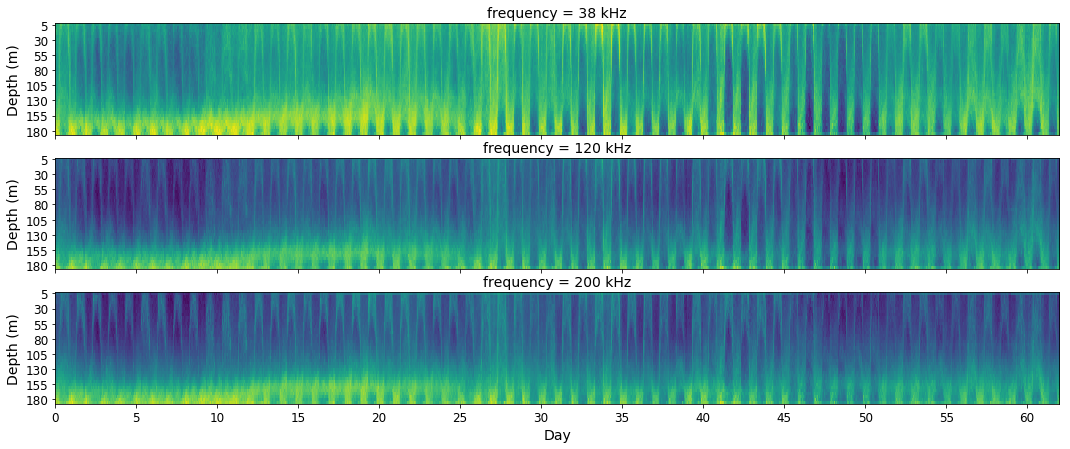

In [17]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep[f,:,:,:].squeeze()),mode=1),aspect='auto')
    ax[f].set_xticks(range(0,65*144,144*5))
    ax[f].set_xticklabels(range(0,65,5))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

Here the y-axis starts at 5 m because I've cut off the top 5 m of data which include a lot of super strong surface reflection that can throw out the decomposition.

The data within each day look like:

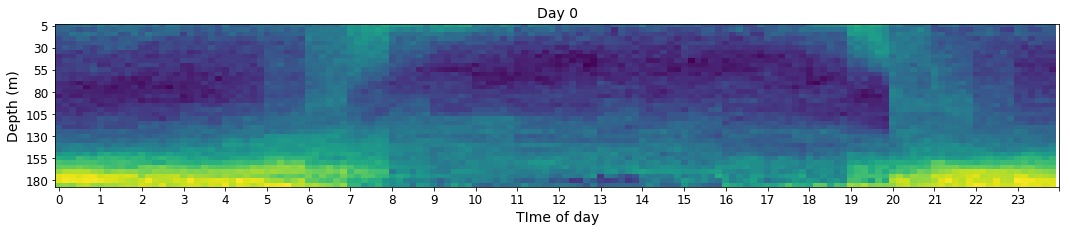

In [18]:
fig = plt.figure(figsize=(18,3))
plt.imshow(L_sep[0,0,:,:].squeeze(),aspect='auto')
plt.xticks(range(0,150,6), range(24), fontsize=12)
plt.yticks(np.arange(0,37,5), (np.arange(0,37,5)+1)*depth_bin_size, fontsize=12)
plt.xlabel('TIme of day', fontsize=14)
plt.ylabel('Depth (m)', fontsize=14)
plt.title('Day 0',fontsize=14)
plt.show()

Note how each hour is a vertical "stripe." This is because the data were collected from only the first 20 mins of each hour, so there is a discontinuity in the raw data itself.

### Try decimating data

In [96]:
# Average across time of day columns
tod_num = 4
L_sep_reduce = np.empty(np.hstack((np.array(L_sep.shape[:3]),int(L_sep.shape[-1]/tod_num))))
for i in np.arange(int(L_sep.shape[-1]/tod_num)):
    L_sep_reduce[:,:,:,i] = np.mean(L_sep[:,:,:,i*tod_num+np.arange(tod_num)],axis=3)

In [97]:
L_sep_reduce.shape

(3, 62, 37, 36)

On the grand scale the decimated data look very similar to without averaging over the pings:

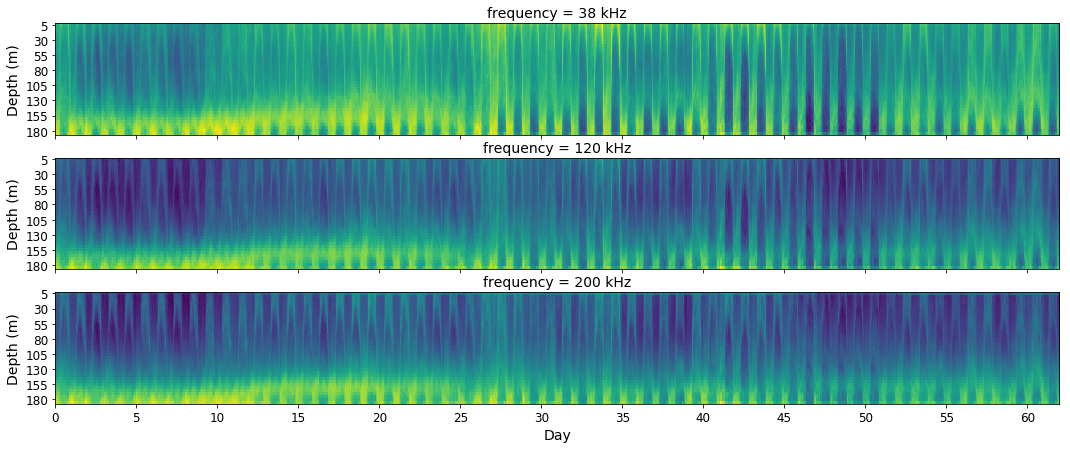

In [98]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep_reduce[f,:,:,:].squeeze()),mode=1),aspect='auto')
    ax[f].set_xticks(range(0,int(65*144/tod_num),int(144/tod_num*5)))
    ax[f].set_xticklabels(range(0,65,5))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

But obviously the effects are more prominent when you look at only a smaller number of days:

First we look at the original MVBS data for the first 10 days:

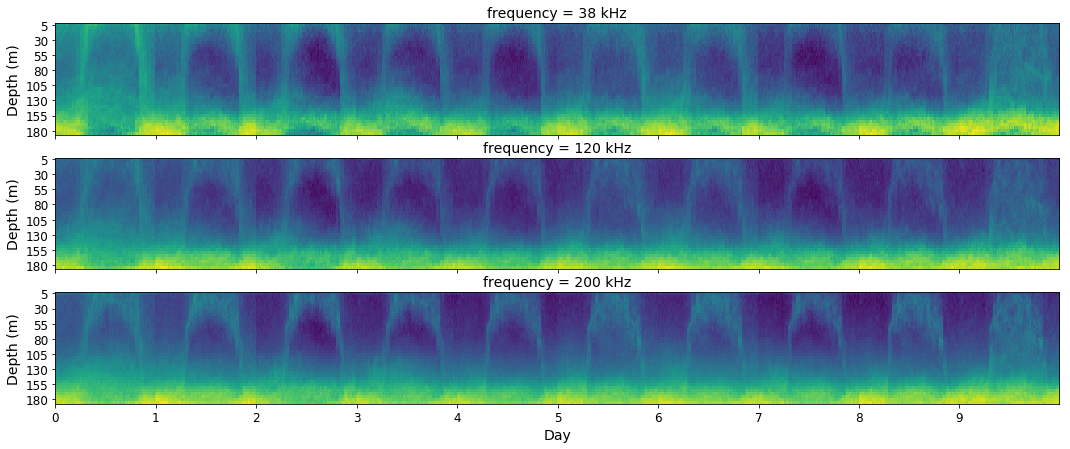

In [99]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep[f,:10,:,:].squeeze()),mode=1),aspect='auto')
    ax[f].set_xticks(range(0,10*144,144))
    ax[f].set_xticklabels(range(0,11,1))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

And then we compare it with the decimated data:

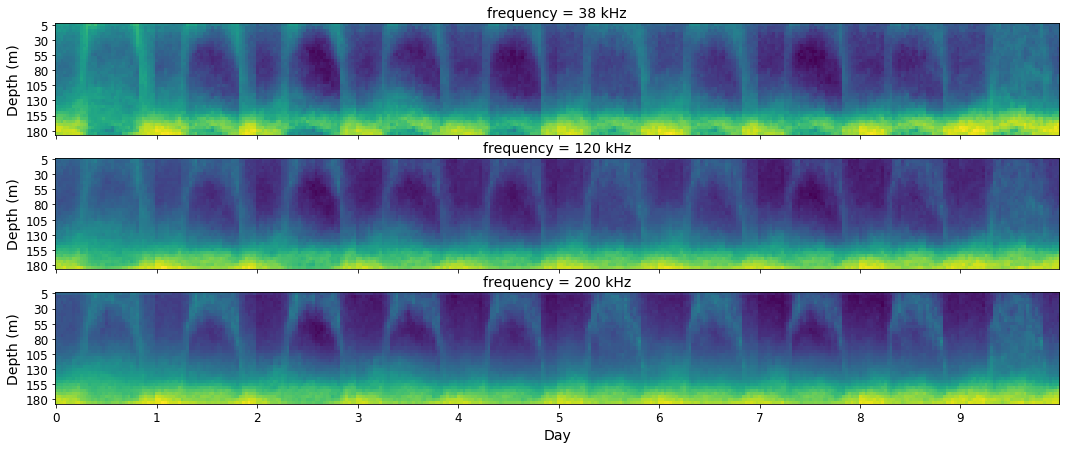

In [100]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep_reduce[f,:10,:,:].squeeze()),mode=1),aspect='auto')
    ax[f].set_xticks(range(0,int(10*144/tod_num),int(144/tod_num*1)))
    ax[f].set_xticklabels(range(0,11,1))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

## Try parafac decomposition

[before]: Here I am using 1 frequency only just to see how things look like. I am not sure if throwing the 3 frequencies and making a 4D tensor makes sense because for that dimension there are only 3 frequencies of observation and this would force the parafac to have max rank=3...

[now]: try to see if can run 4D decomposition

In [101]:
# kruskal decomposition is parafac in tensorly
from tensorly.decomposition import parafac, non_negative_parafac
from tensorly.tenalg import kronecker, khatri_rao

In [102]:
# sonar_tensor = tl.tensor(L_sep)
sonar_tensor = tl.tensor(L_sep_reduce)

In [103]:
sonar_tensor.shape

(3, 62, 37, 36)

### Rank=3

In [143]:
kruskal_rank = 3
factors_kruskal_3 = parafac(sonar_tensor, rank = kruskal_rank)
factors_kruskal_nonneg_3 = non_negative_parafac(sonar_tensor-sonar_tensor.min(), rank = kruskal_rank)

In [144]:
[factors_kruskal_3[f].shape for f in range(len(factors_kruskal_3))]

[(3, 3), (62, 3), (37, 3), (36, 3)]

In [147]:
full_tensor_3 = tl.kruskal_to_tensor(factors_kruskal_3)
full_tensor_nonneg_3 = tl.kruskal_to_tensor(factors_kruskal_nonneg_3)

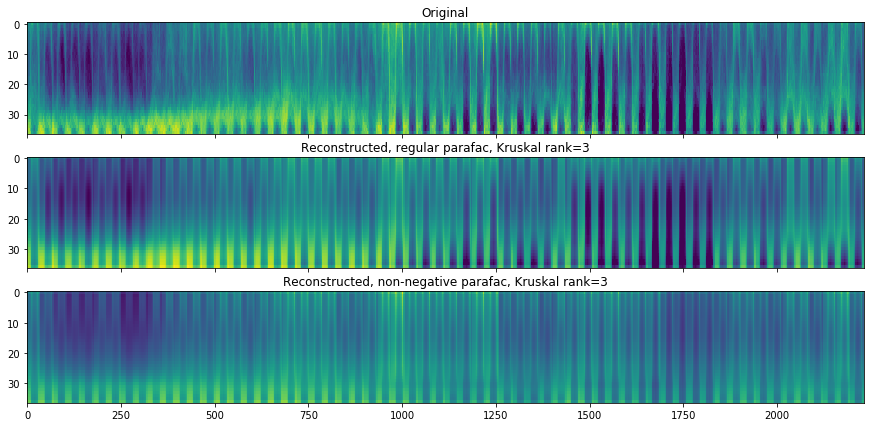

In [152]:
fig,ax = plt.subplots(3,1,figsize=(15,7),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[0,:,:,:]).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[0].set_title('Original')
ax[1].imshow(tl.unfold(tl.tensor(full_tensor_3[0,:,:,:]).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[1].set_title('Reconstructed, regular parafac, Kruskal rank=%d'%kruskal_rank)
ax[2].imshow(tl.unfold(tl.tensor(full_tensor_nonneg_3[0,:,:,:]+sonar_tensor.min()).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[2].set_title('Reconstructed, non-negative parafac, Kruskal rank=%d'%kruskal_rank)
plt.show()

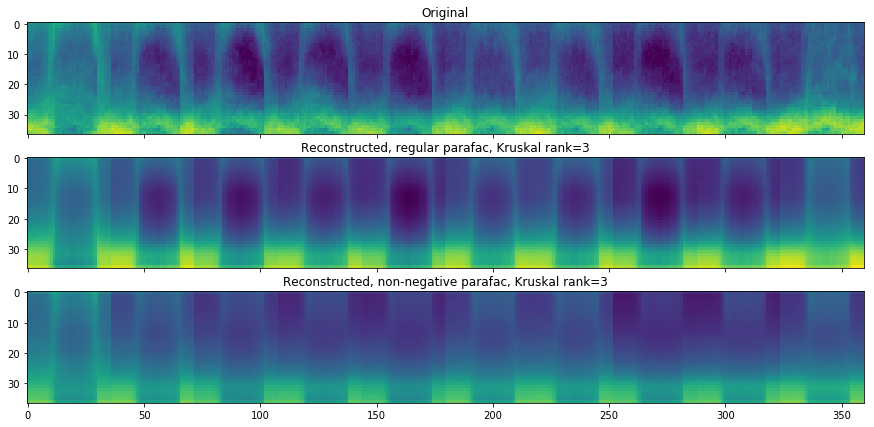

In [153]:
fig,ax = plt.subplots(3,1,figsize=(15,7),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[0,:10,:,:]).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[0].set_title('Original')
ax[1].imshow(tl.unfold(tl.tensor(full_tensor_3[0,:10,:,:]).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[1].set_title('Reconstructed, regular parafac, Kruskal rank=%d'%kruskal_rank)
ax[2].imshow(tl.unfold(tl.tensor(full_tensor_nonneg_3[0,:10,:,:]+sonar_tensor.min()).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[2].set_title('Reconstructed, non-negative parafac, Kruskal rank=%d'%kruskal_rank)
plt.show()

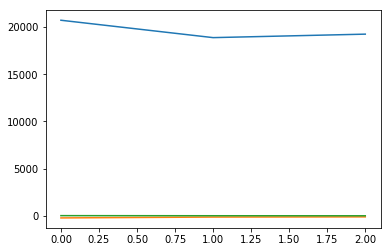

In [154]:
plt.plot(factors_kruskal_3[0])
plt.show()

In [155]:
# Khatri-kao product to combine the factors
kr01_3 = khatri_rao((factors_kruskal_3[0],factors_kruskal_3[1]))
kr02_3 = khatri_rao((factors_kruskal_3[0],factors_kruskal_3[2]))
kr03_3 = khatri_rao((factors_kruskal_3[0],factors_kruskal_3[3]))
kr12_3 = khatri_rao((factors_kruskal_3[1],factors_kruskal_3[2]))
kr13_3 = khatri_rao((factors_kruskal_3[1],factors_kruskal_3[3]))
kr23_3 = khatri_rao((factors_kruskal_3[2],factors_kruskal_3[3]))

In [156]:
dim = sonar_tensor.shape

In [157]:
dim

(3, 62, 37, 36)

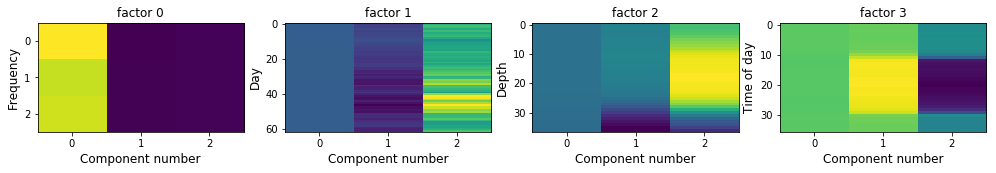

In [158]:
fig,ax = plt.subplots(1,4,figsize=(17,2))
for i in range(4):
    ax[i].imshow(factors_kruskal_3[i],aspect='auto')
    ax[i].set_title('factor %d' % i)
    ax[i].set_xlabel('Component number',fontsize=12)
    if i==0:
        ax[i].set_ylabel('Frequency',fontsize=12)
    elif i==1:
        ax[i].set_ylabel('Day',fontsize=12)
    elif i==2:
        ax[i].set_ylabel('Depth',fontsize=12)
    else:
        ax[i].set_ylabel('Time of day',fontsize=12)
    ax[i].set_xticks(np.arange(kruskal_rank))

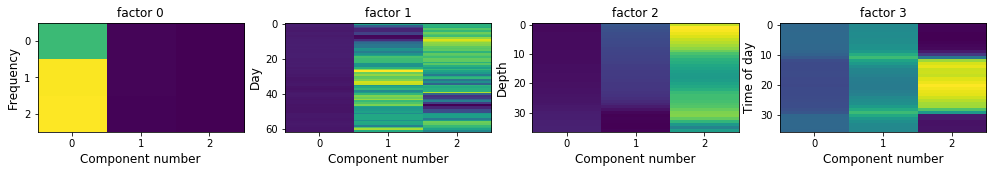

In [159]:
fig,ax = plt.subplots(1,4,figsize=(17,2))
for i in range(4):
    ax[i].imshow(factors_kruskal_nonneg_3[i],aspect='auto')
    ax[i].set_title('factor %d' % i)
    ax[i].set_xlabel('Component number',fontsize=12)
    if i==0:
        ax[i].set_ylabel('Frequency',fontsize=12)
    elif i==1:
        ax[i].set_ylabel('Day',fontsize=12)
    elif i==2:
        ax[i].set_ylabel('Depth',fontsize=12)
    else:
        ax[i].set_ylabel('Time of day',fontsize=12)
    ax[i].set_xticks(np.arange(kruskal_rank))

### Rank=4

In [160]:
kruskal_rank = 4
factors_kruskal_4 = parafac(sonar_tensor, rank = kruskal_rank)
factors_kruskal_nonneg_4 = non_negative_parafac(sonar_tensor-sonar_tensor.min(), rank = kruskal_rank)

In [161]:
[factors_kruskal_4[f].shape for f in range(len(factors_kruskal_4))]

[(3, 4), (62, 4), (37, 4), (36, 4)]

In [164]:
full_tensor_4 = tl.kruskal_to_tensor(factors_kruskal_4)
full_tensor_nonneg_4 = tl.kruskal_to_tensor(factors_kruskal_nonneg_4)

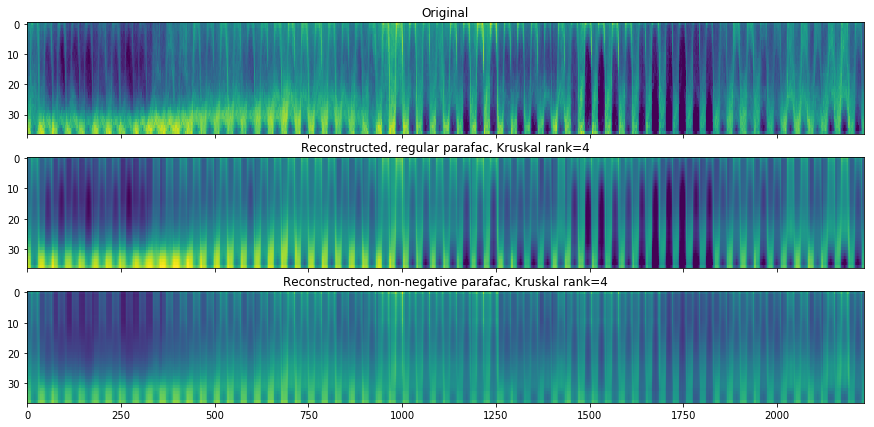

In [165]:
fig,ax = plt.subplots(3,1,figsize=(15,7),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[0,:,:,:]).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[0].set_title('Original')
ax[1].imshow(tl.unfold(tl.tensor(full_tensor_4[0,:,:,:]).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[1].set_title('Reconstructed, regular parafac, Kruskal rank=%d'%kruskal_rank)
ax[2].imshow(tl.unfold(tl.tensor(full_tensor_nonneg_4[0,:,:,:]+sonar_tensor.min()).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[2].set_title('Reconstructed, non-negative parafac, Kruskal rank=%d'%kruskal_rank)
plt.show()

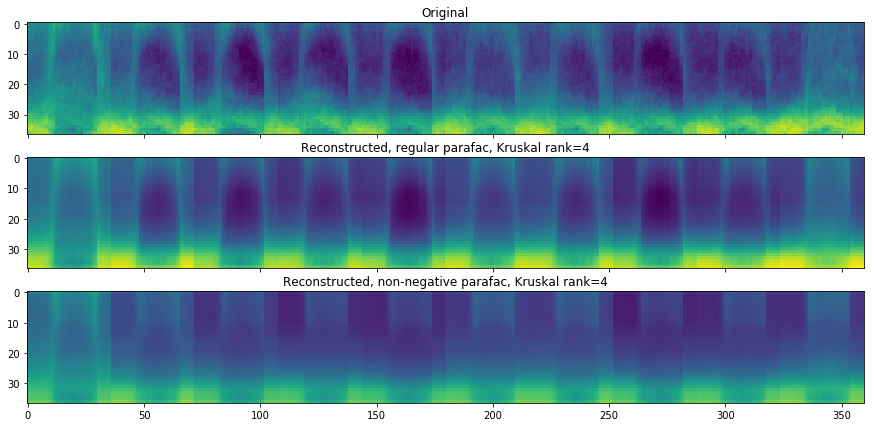

In [166]:
fig,ax = plt.subplots(3,1,figsize=(15,7),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[0,:10,:,:]).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[0].set_title('Original')
ax[1].imshow(tl.unfold(tl.tensor(full_tensor_4[0,:10,:,:]).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[1].set_title('Reconstructed, regular parafac, Kruskal rank=%d'%kruskal_rank)
ax[2].imshow(tl.unfold(tl.tensor(full_tensor_nonneg_4[0,:10,:,:]+sonar_tensor.min()).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[2].set_title('Reconstructed, non-negative parafac, Kruskal rank=%d'%kruskal_rank)
plt.show()

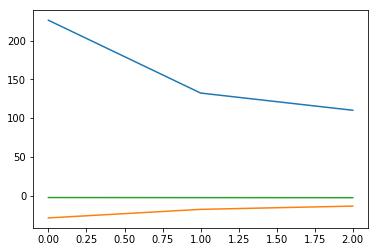

In [167]:
plt.plot(factors_kruskal[0][:,1:])
plt.show()

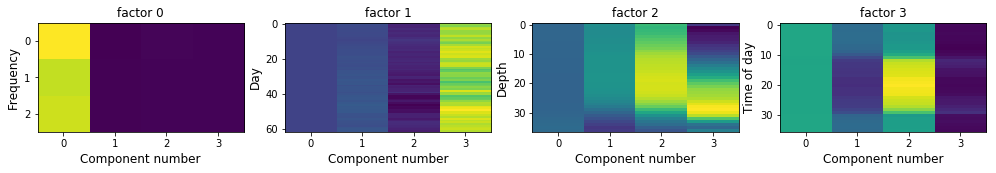

In [168]:
fig,ax = plt.subplots(1,4,figsize=(17,2))
for i in range(4):
    ax[i].imshow(factors_kruskal_4[i],aspect='auto')
    ax[i].set_title('factor %d' % i)
    ax[i].set_xlabel('Component number',fontsize=12)
    if i==0:
        ax[i].set_ylabel('Frequency',fontsize=12)
    elif i==1:
        ax[i].set_ylabel('Day',fontsize=12)
    elif i==2:
        ax[i].set_ylabel('Depth',fontsize=12)
    else:
        ax[i].set_ylabel('Time of day',fontsize=12)
    ax[i].set_xticks(np.arange(kruskal_rank))

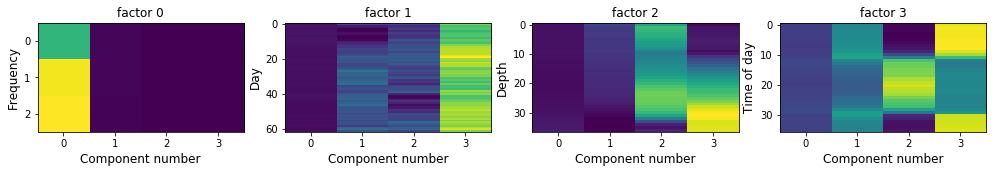

In [169]:
fig,ax = plt.subplots(1,4,figsize=(17,2))
for i in range(4):
    ax[i].imshow(factors_kruskal_nonneg_4[i],aspect='auto')
    ax[i].set_title('factor %d' % i)
    ax[i].set_xlabel('Component number',fontsize=12)
    if i==0:
        ax[i].set_ylabel('Frequency',fontsize=12)
    elif i==1:
        ax[i].set_ylabel('Day',fontsize=12)
    elif i==2:
        ax[i].set_ylabel('Depth',fontsize=12)
    else:
        ax[i].set_ylabel('Time of day',fontsize=12)
    ax[i].set_xticks(np.arange(kruskal_rank))